## Document Question Answering 모델을 이용한 영수증 인식 프로그램 만들어보기
---
컴퓨터는 디지털 데이터는 제대로 읽을 수 있지만, 사람이 손으로 적거나 인쇄한 아날로그 데이터는 읽지 못합니다. 그래서, 아날로그 데이터는 카메라로 찍거나 스캔을 한 뒤 OCR(Optical Character Recognition, 광학 문자 인식) 기술을 이용해 문자를 디지털화한 다음 데이터 분석 또는 정리에 이용합니다. 하지만, OCR은 글자를 인식한다뿐이지 이미지 안에 있는 위치에 따른 데이터의 관계를 파악할 수 없기 때문에 별도의 정리를 해야 유의미한 데이터로 써먹을 수 있습니다.  
</p></br></br>


만약, 자동차 번호판 인식이나 종이책을 스캔한 뒤, 인식한 글자를 출력하는 것과 같은 프로세스는 구현이 간단합니다. 글자의 위치나 관계가 일정하고, 이를 이용한 데이터 활용이 제한적인 경우에는 OCR 기술과 적절한 전처리를 이용한다면 100%에 가까운 정확도를 보여주면서 이용에 불편함이 없는 모델을 만들 수 있습니다. 하지만, 글자를 인식해야 한다는 점은 동일하지만 글 양식이나 표의 배치가 제멋대로인 문서들을 여럿 처리해야 한다면, 혹은 읽어낸 데이터를 제3자가 이용한다면 기존의 OCR 기술을 이용하는데는 한계가 있지요. 그래서, 이런 문제는 문서 질의응답(Document Question Answering) 모델을 사용해서 해결할 수 있답니다. 이번에는 영수증 인식 프로그램을 만들어보면서 이 모델의 특징을 알아보도록 하겠습니다.  
</p></br></br>


Document Question Answering 모델은 문서 이미지에서 글자를 추출하고, 글자의 배치에 따른 관계를 인식해 자연어 질문에 답변하는 모델입니다. 예를 들어, 임의의 표를 사진으로 찍어서 입력하면 전처리 없이도 그 사진의 정보를 읽어서 질의응답을 할 수 있다는 말입니다. 이런 특징은 아날로그 문서 관리에 강점이 있는데요, 이 기술을 이용해서 네이버 마이플레이스 영수증리뷰와 같은 시스템을 손쉽게 구현할 수 있답니다.  
</p></br></br>


이번에는 Document Question Answering 모델을 이용해서 영수증 인식 프로그램을 만들어 볼텐데요, 이 과정에는 [Naver CLOVA INFORMATION EXTRACTION](https://huggingface.co/naver-clova-ix)에서 제공하는 [Donut base finetuned DocVQA](https://huggingface.co/naver-clova-ix/donut-base-finetuned-docvqa) 모델을 이용해 보겠습니다.  
</p></br></br>



C:\ProgramData\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


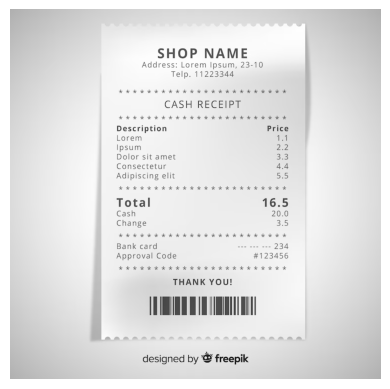

In [1]:
# 패키지 불러오기
from transformers import pipeline
from PIL import Image
from googletrans import Translator
import matplotlib.pyplot as plt

# DocQA모델 및 영수증 이미지 불러오기
pipe = pipeline("document-question-answering", model="naver-clova-ix/donut-base-finetuned-docvqa")
document = Image.open('./figure/receipt.png')

plt.imshow(document)
plt.axis(False)
plt.show()

</p></br></br>


예시에 사용할 영수증 이미지는 위와 같습니다. 사람의 경우에는 영수증 사진을 보고는 바로 어떤 품목이 얼마인지를 인식할 수 있지만, 컴퓨터는 글자의 위치에 따른 관계를 이해하지 못하기 때문에 이를 이해하기 어렵습니다. 만약 글자 위치에 따라 표를 만든다 해도, Description, Price 등의 키워드를 꼭 명시해 줘야 해당 값을 구할 수 있지요. 하지만 Document Question Answering 모델은 다릅니다. 이 영수증에서 Ipsum이 얼마인지 자연어로 물어보도록 합시다.  
</p></br></br>



In [2]:
# 질문 입력 및 답변 도출
question = 'How much is Ipsum?'
answer = pipe(image=document, question=question)
print(answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\ProgramData\anaconda3\lib\site-packages\transformers\generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'answer': '2.2'}]


</p></br></br>


Document Question Answering 모델에 `How much is Ipsum?` 이라고 질문을 하자, `2.2`라고 답변을 합니다. 일반적인 표 형식 데이터를 검색한다면 `df[df['Description'] == 'Ipsum]['Price']` 와 같이 코드를 짜야 했겠지만, 이 모델은 Description 및 Price 정보라고 명시하지 않아도 알아서 해당 정보를 찾아가는 편리함을 보여줍니다. 그렇다면, 정보를 더욱 간접적으로 요구해 보면 어떨까요?  
</p></br></br>



In [3]:
# 질문 입력 및 답변 도출
question = 'I want buy Ipsum.'
answer = pipe(image=document, question=question)
print(answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[{'answer': '2.2'}]


</p></br></br>


이번에는 Ipsum의 가격을 직접 물어보지 않고, Ipsum을 사고 싶다는 말을 적었습니다. 사람의 경우에는 `사고 싶다 == 가격이 궁금하다` 라고 이해할 수 있지만, 컴퓨터는 이러한 논리가 없기 때문에 전통적인 검색 방법으로는 가격을 제시하도록 만들기가 어렵습니다. 하지만, 이번에 사용한 Document Question Answering 모델은 자연어 인식이 가능하기 때문에 구매 의도를 가격으로 연결한 모습을 확인할 수 있습니다.